# Gradient Descent

In the last part we defined the leaning problem as finding a target function $f$ from $X$ to $Y$. Because we are sure their is a hidden pattern , that could be expressed in a function $f$ and we are not able to pin it down, we want to learn it based on observed data. Our formulation of the learning problem makes use of a parametrized function $h_{\theta}$, that should explain the data well. We called it the hypothesis or model.


$$h_{\theta}: X \rightarrow Y: x \mapsto h_{\theta}(x) = \hat{y}$$


If $h_{\theta}$ explains the data well according to an appropriate loss function $L$, than the empirical risk $ER$

$$ER = \frac{1}{m} \sum_{i=1}^{m} L(y^{(i)},h_{\theta}(x^{(i)}))$$

converge according to the weak law of large numbers to the statistical risk and this leads to minimization problem:

$$\hat{h} = \arg \min_{\theta} ER $$

For a given set of datapoints and we define 

$$J(\theta) = \sum_{i=1}^{m} L(y^{(i)},h_{\theta}(x^{(i)}))$$ 

as the sum over all losses for all datapoints as a function of the parameter $\theta$. We call $J$ the **cost** (or **loss**) function. (Instead of the absolute error, we could also use the mean error.)

If $J$ is continuous, differentiable and convex we can solve the minimization problem with hill climbing algorithms. One of these is **Gradient Descent**, able to find a local Minimum of a differentiable reel-valued function on $R^n$.

$$\min_{\theta \in R^n} J(\theta)$$

The idea behind Gradient Descent is to approach the solution step by step. The gradient of a function points in the direction in which the function increases the most (the negative gradient does the opposite). 

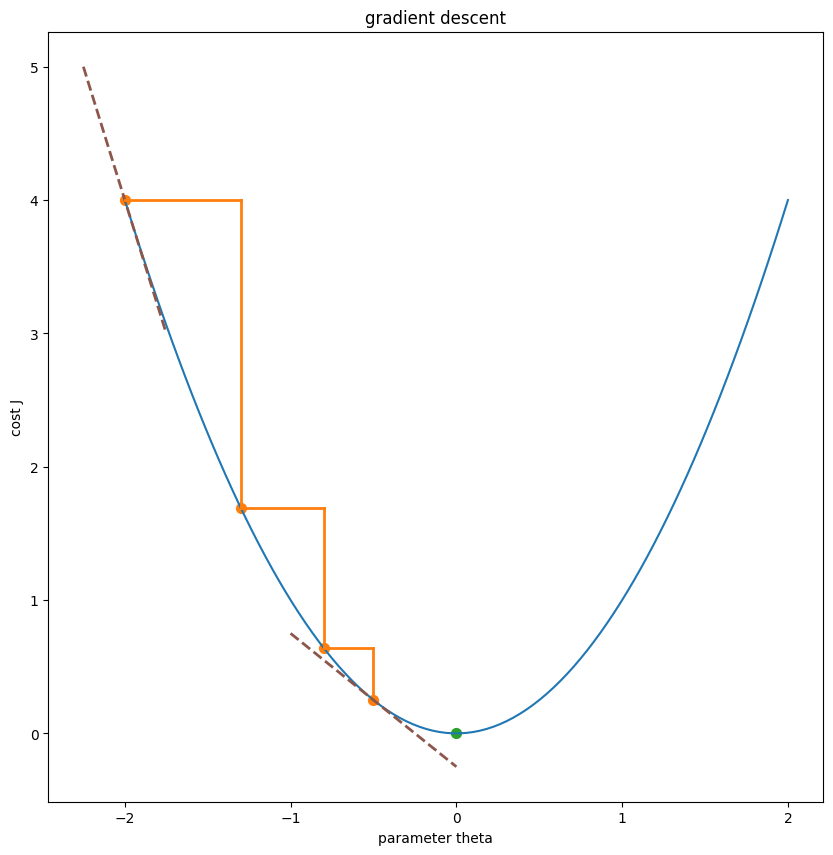

In [1]:
import matplotlib.pyplot as plt
import numpy as np

f=lambda x:x**2
gradient=lambda x:2*x
        
# y = m*(x - x1) + y1
def tangent(x, x1, y1):
    return gradient(x1)*(x - x1) + y1

x1 = -2
y1 = f(x1)

# data 
x = np.linspace(-2,2,100)

fig, ax = plt.subplots(figsize=(10,10))
ax.plot(x, f(x))

xrange = np.linspace(x1-0.25, x1+0.25, 10) #data range for tangent line
ax.plot(xrange, tangent(xrange, x1, y1), 'C5--', linewidth = 2)

steps = [0.7, 0.5, 0.3]
for step in steps:
    
    ax.scatter(x1, y1, color='C1', s=50)
    
    xstep  = np.linspace(x1, x1+step, 10) #data range for step
    ystep  = np.linspace(y1, y1, 10)
    ax.plot(xstep, ystep, 'C1', linewidth = 2)
    
    ax.plot([x1+step, x1+step], [f(x1+step), y1], 'C1', linewidth = 2)
    x1 = x1+step
    y1 = f(x1)

ax.scatter(x1,y1 , color='C1', s=50)
xrange = np.linspace(x1-0.5, x1+0.5, 10) #data range for tangent line
ax.plot(xrange, tangent(xrange, x1, y1), 'C5--', linewidth = 2, )
ax.scatter(0,0 , color='C2', s=50)
ax.set_xlabel("parameter theta")
ax.set_ylabel("cost J")
ax.set_title("gradient descent")
plt.show()

## Gradient Descent (GD) Algorithm


Let $J$ be a convex, continuous and differentiable function. We want to minimize $J(\theta)$. (Find a $\theta$ where $J$ has a minimum.)

1. Initialization: Choose a starting point $\theta_{0} \in R^n$, a tolerence $\delta > 0$ and a step size $\lambda > 0$, we call it the **learning rate**. 
2. Calculate gradient at this point $\nabla J(\theta_{0})$. (The first derivative with respect to $\theta$. This is a vector for $\theta \in R^n$!)
3. Make a step in the opposite direction of the gradient:
$$ \theta_{t+1} = \theta_{t} - \lambda * \nabla J(\theta_{t})$$
4. Repeat (2) and (3) until one of the criteria is met:
    - maximum number of iterations reached
    - step size is smaler than tolerence: $distance(\theta_{t+1}, \theta_{t}) < \delta$.



If you want to have a look at the proof, that GD converges, than have a look at https://www.cs.cornell.edu/courses/cs4780/2022sp/notes/Notes11.pdf

## Gradient Descent with PyTorch
The challenge with gradient descent is that we have to calculate the gradient $\nabla J(\theta)$. But the good thing is that PyTorch will do it for us. 

Numpy is a library for numerical computation, and it is widely used for handling arrays and matrices. On the other hand, PyTorch is a deep learning library that provides efficient tensor operations and **automatic differentiation**.

### Start with some toy data
Lets start making some toy data with numpy, following a linear function with some random error:


$$f(y) = w * x + b + error$$


Hint: For reproducibility you could use *seed* to initialize the random number generator in python, numpy and torch:
```
import torch
torch.manual_seed(0)

import random
random.seed(0)

import numpy as np
np.random.seed(0)
```
see: https://pytorch.org/docs/stable/notes/randomness.html

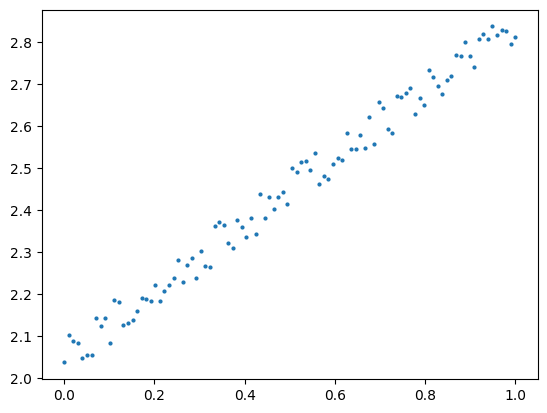

In [2]:
np.random.seed(42)

w, b = 0.8, 2 #the real parameters, we want to learn

error = np.random.random(size=100) / 10 #put some noise into the data

f = lambda x: w * x + b + error

# 100 data points between 0 and 1.
X_np = np.linspace(start=0, stop=1, num=100) 
y_np = f(X_np)

plt.scatter(X_np ,y_np, s=4)
plt.show()

### Create a Pytorch tensor from numpy array

Default dtype dimension in numpy.array is 64 instead of 32 in torch.tensor. So we have to cast numpy.array to a torch.tensor. Use

```
torch.tensor.from_numpy(x).to(dtype=torch.float32)
```

We use for plotting numpy.array and for gradient computation torch.tensor. (torch.tensor objects could been ploted by matplotlib, because they do not have ndim attribute. But you could fix it with 
```
torch.Tensor.ndim = property(lambda self: len(self.shape)) 
```

In [3]:
import torch
print(type(X_np.dtype), X_np.dtype)
X = torch.from_numpy(X_np).to(dtype=torch.float32)
y = torch.from_numpy(y_np).to(dtype=torch.float32)
print(type(X.dtype), X.dtype)

<class 'numpy.dtypes.Float64DType'> float64
<class 'torch.dtype'> torch.float32


### Split the data into train and test data

When splitting the data into train and test, normally you use 80% training and 20% test data.

There are several ways to split our data. Assume we hav 100 data points. What would happen, if you split the data like

```
X_train = X[0:80], y_train = y[0:80]
X_test  = X[80:],  y_test  = y[80:]

```

Are you shure that the first 80 data points are drown by the same probability distribution? Are your data iid? Or do we have some dependence or correlation in time?

In [4]:
# Lets shuffle the data before we split it. 
# Looks complicated, but its a good practice to work with data. 
# Later we will use some tools to do the work for us.

# 1.) stack the two tensors X, y together. 
print("shape of X and y        :", X.shape, y.shape)
dataset = torch.stack((X, y))
print("shape of stacked dataset:",dataset.shape)
dataset = dataset.T
print("shape of transpose      :",dataset.shape)

# 2.) shuffe the data - make some permutations that preseves X_i and y_i staying together. 
torch.manual_seed(42)
dataset = dataset[torch.randperm(dataset.size()[0])]

# 3.) get back X and y from dataset. 
X = dataset[:,0]
y = dataset[:,1]

# 4.) define splitting constant 80% train data and 20% test data.
splitt = int(0.8 * len(X))
X_train = X[0:splitt]
X_test  = X[splitt:] 
y_train = y[0:splitt]
y_test  = y[splitt:]
print("shape of X and y (train):", X_train.shape, y_train.shape)
print("shape of X and y (test) :", X_test.shape, y_test.shape)

shape of X and y        : torch.Size([100]) torch.Size([100])
shape of stacked dataset: torch.Size([2, 100])
shape of transpose      : torch.Size([100, 2])
shape of X and y (train): torch.Size([80]) torch.Size([80])
shape of X and y (test) : torch.Size([20]) torch.Size([20])


In [5]:
#### Use pytorch data utilities DataSet and DataLoader: https://pytorch.org/docs/stable/data.html
torch.manual_seed(42)
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)

test_dataset = TensorDataset(X_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=False)

In [6]:
for x,y in train_dataloader: #batch size defines, how many data points are used in one step
    print(x.shape, y.shape)  #we have defines a batch size of 20

torch.Size([20]) torch.Size([20])
torch.Size([20]) torch.Size([20])
torch.Size([20]) torch.Size([20])
torch.Size([20]) torch.Size([20])


### Define a linear model that fit the data well

In [7]:
#### Define a linear model that fits the data assuming a linear correlation  (Running Linear Regression)
def model(x):
    return w * x + b

### Use Mean Squared Error as Cost Function

$$J(w,b) = 1/N \sum_{i=1}^{N} (y^{(i)} - (w x^{(i)} + b))^2$$ 

with Gradient $\nabla J(w,b)$

$$dJ/dw = 1/N \sum_{i=1}^{N} -2x^{(i)}(y^{(i)}-(w x^{(i)} + b))$$

$$dJ/db = 1/N \sum_{i=1}^{N} -2(y^{(i)}-(w x^{(i)} + b))$$
                


In [8]:
#### Define a loss function (Mean Squared Error)
def mse_loss(predictions, targets):
    d = predictions - targets
    return torch.mean(d * d)

### Train the model 

For Training we use build in backpropagation:

- for computation we go in forward direction through the computation graph
- for gradient computation we go backwars through the computation graph: The function 
    ```
    tensor.backwards() 
    ```
computes the gradient of current tensor with respect to graph leaves.


see:  https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html


In [9]:
x = torch.tensor([0.5])
y = torch.tensor([0.8*x+2])    # real y without error

y_hat = model(x)
print(y_hat)

loss = mse_loss(y_hat, y)
print(loss)

tensor([2.4000])
tensor(0.)


In [10]:
w = torch.rand(size=(1,1), requires_grad=True) # initialize start parameter w
b = torch.rand(size=(1,1), requires_grad=True) # initialize start parameter b

epochs = 200                     #epoch defines how often we iterate over the whole dataset
lr = 0.01                        #try it with different learning rates and different epochs
for epoch in range(epochs):      
    for x,y in train_dataloader: #batch size in dataloader defines, how many data points are used in one step
        y_hat = model(x)         # --> forward computation
        loss = mse_loss(y_hat, y)
        
        loss.backward()          # <-- backpropagation
        with torch.no_grad():    
            w -= w.grad * lr
            b -= b.grad * lr
            w.grad.zero_()       # set gradient to zero
            b.grad.zero_()
        
    if epoch % 20 == 0:
        print(f"Epoch: {epoch} loss {loss}")
        print(f"       {w=} {b=}")

Epoch: 0 loss 2.315269708633423
       w=tensor([[0.4583]], requires_grad=True) b=tensor([[0.7283]], requires_grad=True)
Epoch: 20 loss 0.041564565151929855
       w=tensor([[0.9840]], requires_grad=True) b=tensor([[1.7564]], requires_grad=True)
Epoch: 40 loss 0.008076940663158894
       w=tensor([[1.0276]], requires_grad=True) b=tensor([[1.8977]], requires_grad=True)
Epoch: 60 loss 0.0038377526216208935
       w=tensor([[1.0129]], requires_grad=True) b=tensor([[1.9265]], requires_grad=True)
Epoch: 80 loss 0.004827738739550114
       w=tensor([[0.9929]], requires_grad=True) b=tensor([[1.9400]], requires_grad=True)
Epoch: 100 loss 0.00355815258808434
       w=tensor([[0.9741]], requires_grad=True) b=tensor([[1.9508]], requires_grad=True)
Epoch: 120 loss 0.002635977230966091
       w=tensor([[0.9570]], requires_grad=True) b=tensor([[1.9601]], requires_grad=True)
Epoch: 140 loss 0.003639587666839361
       w=tensor([[0.9416]], requires_grad=True) b=tensor([[1.9685]], requires_grad=True)
E

In [11]:
print(w.item(), b.item())

0.9045760631561279 1.9888169765472412


In [12]:
y_hat = model(X_train)
print(mse_loss(y_hat, y_train).detach().numpy())

0.0018012546


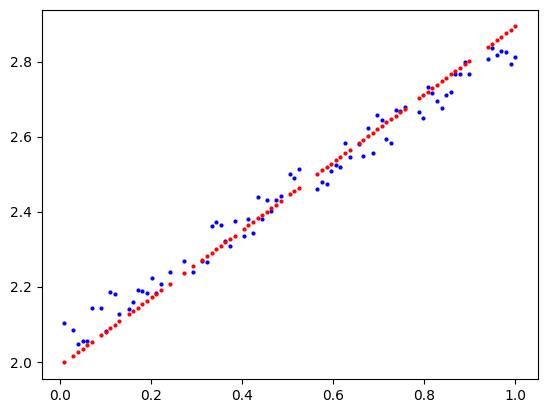

In [13]:
plt.scatter(X_train.detach().numpy(), y_train.detach().numpy(), s=4, c="b")
plt.scatter(X_train.detach().numpy(), y_hat.detach().numpy(), s=4, c="r")
plt.show()

In [14]:
####### now test our model
y_hat = model(X_test)
loss = mse_loss(y_hat, y_test)
print(loss.detach().numpy())

0.0018171469


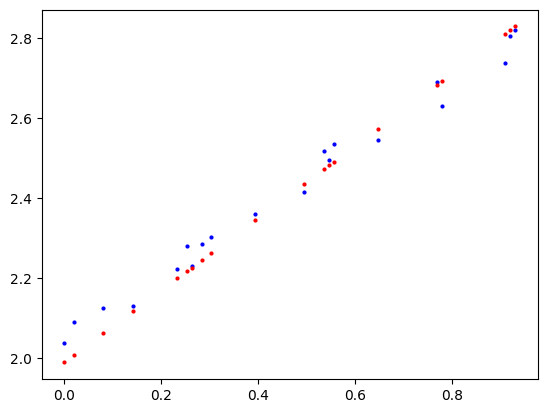

In [15]:
plt.scatter(X_test.numpy(), y_test.numpy(), s=4, c="b")
plt.scatter(X_test.numpy(), y_hat.detach().numpy(), s=4, c="r")
plt.show()

### Now use more PyTorch

- use PyTorch Module: Base calss or all neural network modules. https://pytorch.org/docs/stable/generated/torch.nn.Module.html
- use PyTorch Loss functions: https://pytorch.org/docs/stable/nn.html#loss-functions
- use PyTorch Optimizer:  https://pytorch.org/docs/stable/optim.html

In [16]:
#### Running a Single Cell Linear Regression
import torch.nn as nn

class LR(nn.Module):
    
    def __init__(self):
        super().__init__()
    
        self.w = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float32))
        self.b = nn.Parameter(torch.rand(1, requires_grad=True, dtype=torch.float32))
        
    def forward(self, x):
        return self.w * x + self.b
    

In [17]:
torch.manual_seed(42)
model = LR()
list(model.parameters())

[Parameter containing:
 tensor([0.8823], requires_grad=True),
 Parameter containing:
 tensor([0.9150], requires_grad=True)]

In [18]:
mse_loss = torch.nn.MSELoss()

In [19]:
from torch.optim import SGD, Adam
#optimizer = SGD(model.parameters(), lr=0.01)
optimizer = Adam(model.parameters(), lr=0.01) # put inside the parameters to optimize and the learning rate

In [20]:
torch.manual_seed(42)
epochs = 1000
for epoch in range(epochs):
    model.train()
    for x,y in train_dataloader:
        y_hat = model(x)
        loss = mse_loss(y_hat, y)
        
        # 3. Optimizer zero grad
        optimizer.zero_grad() # necessary for each epoch, because the optimizer accumulate the gradient changes
    
        # 4. Perform Backpropagation
        loss.backward()
    
        # 5. Perform Gradient Descent
        optimizer.step()
        
    model.eval()
    with torch.no_grad():
        for x, y in test_dataloader:
            y_test = model(x)
            loss = mse_loss(y_test, y)
            print(f"{epoch} - {loss}")
    

0 - 1.085282802581787
1 - 0.9695798754692078
2 - 0.8617781400680542
3 - 0.762137770652771
4 - 0.6708019375801086


5 - 0.5880385637283325
6 - 0.513375461101532
7 - 0.4465913772583008
8 - 0.3874083459377289
9 - 0.33536404371261597
10 - 0.2900178134441376
11 - 0.2507554590702057
12 - 0.21701779961585999
13 - 0.18818755447864532
14 - 0.16402238607406616
15 - 0.14356574416160583
16 - 0.1265309751033783
17 - 0.11245491355657578
18 - 0.1007598489522934
19 - 0.09123001992702484
20 - 0.08342155814170837
21 - 0.07694365084171295
22 - 0.07176779210567474
23 - 0.06744690239429474
24 - 0.06389309465885162
25 - 0.06098318099975586
26 - 0.058494795113801956
27 - 0.05631666257977486
28 - 0.05450577661395073
29 - 0.05283915251493454
30 - 0.0513727180659771
31 - 0.050133466720581055
32 - 0.04890124872326851
33 - 0.04773261398077011
34 - 0.0466906800866127
35 - 0.04572494700551033
36 - 0.04475390911102295
37 - 0.04384331777691841
38 - 0.042972031980752945
39 - 0.042073722928762436
40 - 0.04124293103814125
41 - 0.04035354405641556
42 - 0.039572589099407196
43 - 0.03878885507583618
44 - 0.037979692220687866
45 - 0.037

111 - 0.006042531691491604
112 - 0.005840799305588007
113 - 0.005650419741868973
114 - 0.005461142864078283
115 - 0.005290822125971317
116 - 0.0051302253268659115
117 - 0.004961219150573015
118 - 0.004810169339179993
119 - 0.0046656448394060135
120 - 0.004523790441453457
121 - 0.0043843770399689674
122 - 0.00424115639179945
123 - 0.004117914009839296
124 - 0.003992076497524977
125 - 0.0038636878598481417
126 - 0.003747212467715144
127 - 0.0036365233827382326
128 - 0.0035227935295552015
129 - 0.0034072096459567547
130 - 0.0033001950941979885
131 - 0.0032001822255551815
132 - 0.003095383057370782
133 - 0.0030056049581617117
134 - 0.0029187817126512527
135 - 0.0028439124580472708
136 - 0.0027632652781903744
137 - 0.0026834593154489994
138 - 0.0026084408164024353
139 - 0.0025305154267698526
140 - 0.0024507581256330013
141 - 0.0023785035591572523
142 - 0.0023129857145249844
143 - 0.0022467798553407192
144 - 0.002186988480389118
145 - 0.002127949381247163
146 - 0.0020697745494544506
147 - 0.

225 - 0.0007577278884127736
226 - 0.0007575209601782262
227 - 0.0007551852613687515
228 - 0.0007547592977061868
229 - 0.0007541410741396248


230 - 0.000752172083593905
231 - 0.0007504543755203485
232 - 0.0007493285229429603
233 - 0.0007464629015885293
234 - 0.000745039782486856
235 - 0.0007468407857231796
236 - 0.0007447938551194966
237 - 0.0007426847005262971
238 - 0.0007408851524814963
239 - 0.0007416473235934973
240 - 0.0007432063575834036
241 - 0.0007412078557536006
242 - 0.000741632713470608
243 - 0.000740904186386615
244 - 0.0007386660436168313
245 - 0.0007371245301328599
246 - 0.0007362308679148555
247 - 0.000736352929379791
248 - 0.0007364441407844424
249 - 0.0007388232625089586
250 - 0.0007352588581852615
251 - 0.0007323925965465605
252 - 0.0007342447061091661
253 - 0.0007334942929446697
254 - 0.0007355418056249619
255 - 0.0007351384265348315
256 - 0.0007343879551626742
257 - 0.0007315960829146206
258 - 0.0007297125994227827
259 - 0.0007305633625946939
260 - 0.0007293691160157323
261 - 0.0007305053877644241
262 - 0.0007300449069589376
263 - 0.0007316209957934916
264 - 0.0007287359330803156
265 - 0.00073012546636164

346 - 0.0007227328605949879
347 - 0.0007248410256579518
348 - 0.0007266263710334897
349 - 0.0007272056536749005
350 - 0.0007228380418382585
351 - 0.000724643119610846
352 - 0.0007214319193735719
353 - 0.0007231606286950409
354 - 0.0007251945789903402
355 - 0.0007249743212014437
356 - 0.0007233008509501815
357 - 0.0007262824801728129
358 - 0.0007257459801621735
359 - 0.0007258682744577527
360 - 0.0007234319346025586
361 - 0.0007246015011332929
362 - 0.0007243187283165753
363 - 0.0007229942129924893
364 - 0.0007236968958750367
365 - 0.0007228669710457325
366 - 0.0007214852375909686
367 - 0.0007241881685331464
368 - 0.0007241476560011506
369 - 0.0007235879311338067
370 - 0.0007240766426548362
371 - 0.000721096876077354
372 - 0.0007214178331196308
373 - 0.0007240324630402029
374 - 0.0007240180857479572
375 - 0.000722188560757786
376 - 0.0007218554383143783
377 - 0.0007216172525659204
378 - 0.0007222704007290304
379 - 0.0007214511279016733
380 - 0.0007207595626823604
381 - 0.000723279139492

464 - 0.0007205245201475918
465 - 0.0007200957625173032
466 - 0.0007210838375613093
467 - 0.0007189723546616733


468 - 0.0007233912474475801
469 - 0.0007197324302978814
470 - 0.0007230035844258964
471 - 0.0007262112922035158
472 - 0.0007331218803301454
473 - 0.0007326496415771544
474 - 0.0007296016556210816
475 - 0.0007290893117897213
476 - 0.0007274436065927148
477 - 0.0007210398907773197
478 - 0.0007177377701736987
479 - 0.0007165266433730721
480 - 0.0007172184414230287
481 - 0.0007221548003144562
482 - 0.0007198055973276496
483 - 0.0007253399817273021
484 - 0.000728271494153887
485 - 0.0007262100698426366
486 - 0.0007246072054840624
487 - 0.0007263302686624229
488 - 0.0007263742154464126
489 - 0.0007228543981909752
490 - 0.0007188344607129693
491 - 0.0007213391363620758
492 - 0.0007252473151311278
493 - 0.0007286754553206265
494 - 0.0007260325364768505
495 - 0.0007210471085272729
496 - 0.0007202100823633373
497 - 0.0007223362335935235
498 - 0.0007277957047335804
499 - 0.0007257836405187845
500 - 0.0007239052793011069
501 - 0.0007236757664941251
502 - 0.0007262321887537837
503 - 0.0007249451009

581 - 0.0007248918409459293
582 - 0.0007226286688819528
583 - 0.0007295754039660096
584 - 0.0007281015277840197
585 - 0.0007237749523483217
586 - 0.0007268966292031109
587 - 0.0007230390328913927
588 - 0.0007175515638664365
589 - 0.0007215656223706901
590 - 0.0007208120077848434
591 - 0.0007177012739703059
592 - 0.000720642798114568
593 - 0.0007251318311318755
594 - 0.0007309644715860486
595 - 0.0007302332669496536
596 - 0.0007223912398330867
597 - 0.0007165203569456935
598 - 0.0007231696508824825
599 - 0.0007273948285728693
600 - 0.0007231119670905173
601 - 0.0007265697931870818
602 - 0.0007249821210280061
603 - 0.000722163706086576
604 - 0.0007219050312414765
605 - 0.000722781871445477
606 - 0.0007211054908111691
607 - 0.0007201348198577762
608 - 0.0007218068349175155
609 - 0.0007245705928653479
610 - 0.0007267101900652051
611 - 0.0007292785448953509
612 - 0.0007280921563506126
613 - 0.0007238677935674787
614 - 0.0007233115029521286
615 - 0.0007170046446844935
616 - 0.000718400813639

701 - 0.0007340888259932399
702 - 0.0007199647952802479
703 - 0.0007128264405764639


704 - 0.0007198856910690665
705 - 0.0007219461840577424
706 - 0.0007294799434021115
707 - 0.0007316068513318896
708 - 0.0007227313471958041
709 - 0.0007201637490652502
710 - 0.0007161346147768199
711 - 0.0007242732681334019
712 - 0.0007268136832863092
713 - 0.0007200250984169543
714 - 0.0007197114173322916
715 - 0.0007246023742482066
716 - 0.000734322820790112
717 - 0.0007333420217037201
718 - 0.0007224847795441747
719 - 0.0007219589897431433
720 - 0.0007206938462331891
721 - 0.0007159006199799478
722 - 0.0007210765033960342
723 - 0.000720167241524905
724 - 0.000734920846298337
725 - 0.0007297013653442264
726 - 0.0007246750756166875
727 - 0.0007150378660298884
728 - 0.0007304223254323006
729 - 0.0007236293167807162
730 - 0.0007185172289609909
731 - 0.0007188207237049937
732 - 0.000727344595361501
733 - 0.0007283746381290257
734 - 0.0007284619496203959
735 - 0.0007249953341670334
736 - 0.0007204642752185464
737 - 0.0007120895315892994
738 - 0.0007151785539463162
739 - 0.0007226442103274

820 - 0.0007276455289684236
821 - 0.0007199296960607171
822 - 0.0007142256945371628
823 - 0.0007130887825042009
824 - 0.0007245549350045621
825 - 0.0007330647786147892
826 - 0.0007312860689125955
827 - 0.0007224034052342176
828 - 0.0007125422125682235
829 - 0.0007158361258916557
830 - 0.0007208086317405105
831 - 0.0007296443800441921
832 - 0.0007285048486664891
833 - 0.0007291330839507282
834 - 0.0007215135265141726
835 - 0.0007232900243252516
836 - 0.0007231921190395951
837 - 0.0007212294731289148
838 - 0.0007236566743813455
839 - 0.000719908275641501
840 - 0.0007272523362189531
841 - 0.0007240985287353396
842 - 0.0007282577571459115
843 - 0.0007166310679167509
844 - 0.0007148234872147441
845 - 0.0007280317367985845
846 - 0.0007319172145798802
847 - 0.0007249052287079394
848 - 0.0007237407262437046
849 - 0.0007201078697107732
850 - 0.0007241340354084969
851 - 0.0007218807004392147
852 - 0.0007367079961113632
853 - 0.0007311665685847402
854 - 0.0007207252783700824
855 - 0.0007150961901

936 - 0.0007211640477180481
937 - 0.0007197560044005513


938 - 0.0007268751505762339
939 - 0.0007348583312705159
940 - 0.0007255045929923654
941 - 0.0007392411935143173
942 - 0.0007288589258678257
943 - 0.0007084005628712475
944 - 0.00071537378244102
945 - 0.0007225109729915857
946 - 0.0007366155623458326
947 - 0.0007310744840651751
948 - 0.0007231422350741923
949 - 0.0007150965975597501
950 - 0.0007128135766834021
951 - 0.0007215022342279553
952 - 0.0007386532961390913
953 - 0.0007329197833314538
954 - 0.0007386720390059054
955 - 0.0007164140115492046
956 - 0.0007156574865803123
957 - 0.0007170489989221096
958 - 0.0007275637472048402
959 - 0.0007260109996423125
960 - 0.0007192686898633838
961 - 0.000719982257578522
962 - 0.0007474208832718432
963 - 0.0007334616966545582
964 - 0.0007162156980484724
965 - 0.0007122462848201394
966 - 0.0007149780867621303
967 - 0.0007225921144708991
968 - 0.000745164870750159
969 - 0.0007338444702327251
970 - 0.0007256843964569271
971 - 0.0007240250706672668
972 - 0.0007136633503250778
973 - 0.0007234595832414

In [21]:
print(list(model.parameters()))

[Parameter containing:
tensor([0.8027], requires_grad=True), Parameter containing:
tensor([2.0448], requires_grad=True)]


In [22]:
y_hat = model(X_train)
print(mse_loss(y_hat, y_train).detach().numpy())

0.00091515825


<function matplotlib.pyplot.show(close=None, block=None)>

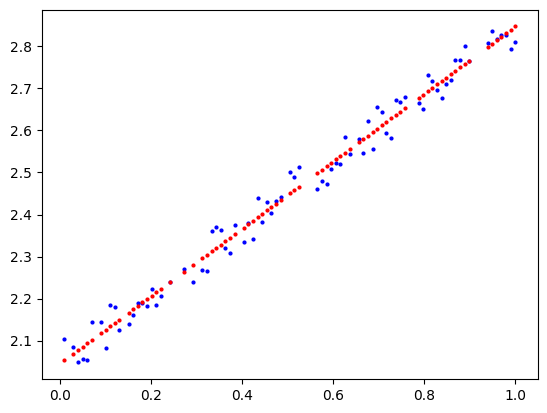

In [23]:
plt.scatter(X_train.numpy(), y_train.numpy(), s=4, c="b")
plt.scatter(X_train.numpy(), y_hat.detach().numpy(), s=4, c="r")
plt.show

In [24]:
y_hat = model(X_test)
print(mse_loss(y_hat, y_test).detach().numpy())

0.0


<function matplotlib.pyplot.show(close=None, block=None)>

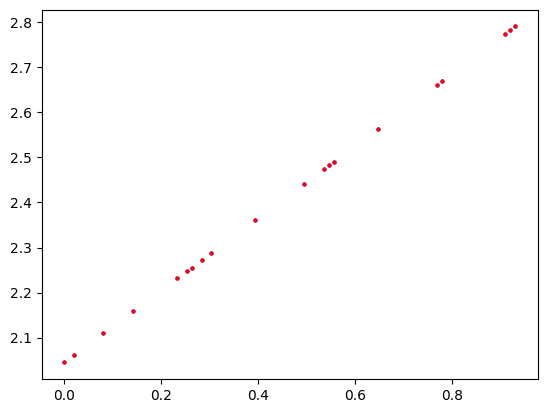

In [25]:
plt.scatter(X_test.numpy(), y_test.numpy(), s=4, c="b")
plt.scatter(X_test.numpy(), y_hat.detach().numpy(), s=4, c="r")
plt.show

- see: https://en.wikipedia.org/wiki/Gradient_descent
- see: http://www.athenasc.com/nonlinbook.html
- see: https://handoutset.com/nonlinear-programming-dimitri-p-bertsekas/
- see: https://optimization.cbe.cornell.edu/index.php?title=Main_Page